## 1. Circular queue

In [1]:
class CircularQueue():

    # constructor
    def __init__(self, size): # initializing the class
        self.n = 0
        self.capacity = size
        # initializing queue with none
        self.queue = [None for i in range(size)]
        self.front = 0
        self.rear = size-1

    def enqueue(self, data):
        # condition if queue is full
        if self.is_full():
            print(" Queue is Full\n")
        else:
            self.rear = (self.rear + 1) % self.capacity
            self.queue[self.rear] = data
            self.n+=1

    def dequeue(self):
        # condition for empty queue
        if self.is_empty():
            raise IndexError("Empty queue: impossible to dequeue")
        # condition for only one element: reset queue
        elif self.n==1:
            temp=self.queue[self.front]
            self.front = 0
            self.rear = self.capacity-1
            self.n=0
            return temp
        else:
            temp = self.queue[self.front]
            self.front = (self.front + 1) % self.capacity
            self.n-=1
            return temp

    def first(self):
        if not self.is_empty():
            return self.queue[self.front]
        else:
            raise IndexError("Empty queue: impossible to peek")

    def len(self):
        return self.n

    def is_empty(self):
        return self.n == 0

    def is_full(self):
        return self.n == self.capacity

    def __str__(self):

        if self.is_empty():
            return "[]"
        else:
            s = ""
            for i in range(self.n):
                temp = (self.front + i) % self.capacity
                s+="["+str(self.queue[temp])+"]"
        return s

## 2. Dinic algorithm


In [2]:
import networkx as nx

class Edge:
  def __init__(self, v, rev, cap, type):
      self.v = v
      self.rev = rev		#see usage in sendFlow function below
      self.cap = cap
      self.flow = 0
      self.type = type		#distinguish forward from backward edges


class Graph:
  def __init__(self, V):
      self.V = V
      self.adj = [[] for _ in range(V)]		#adjacency list

      self.edges = [] #vertex pairs (u,v) representing the edges
      self.edge_index = {}  #dictionary to access (u, v) -> index

      self.posit = list(range(V))
      #let's now map each vertex into its index
      self.posit_map = {v: i for i, v in enumerate(self.posit)}

      #self.level[i] stores the level index of (i+1)-th observed vertex
      self.level = [-1] * V
      self.modif = [] #tracks the modifications applied to edges
      self.nonzeroedges = [] #ones with a non-zero capacity

      self.dicts = [{} for _ in range(V)]   #dictionaries list

  def addEdge(self, u, v, cap):

      #explanation of the following value for edge.rev: see sendFlow function
      #Forward edge : 0 flow and cap capacity
      a = Edge(v, len(self.adj[v]), cap, 1)
      #Backward edge : 0 flow and 0 capacity
      b = Edge(u, len(self.adj[u]), 0, 0)

      self.adj[u].append(a)
      self.adj[v].append(b)
      self.edges.append((u, v))
      self.edge_index[(u, v)] = len(self.edges) - 1 # store the index of the edge (u,v) in the edges list
      self.modif.append(0)

      #use self.dicts[u] to store, for the key v, the position
      #where v has been saved in the self.adj[u] list
      self.dicts[u][v] = len(self.adj[u]) - 1
      self.dicts[v][u] = len(self.adj[v]) - 1

  def BFS(self, s, t):
      self.level = [-1] * self.V
      self.level[self.posit_map[s]] = 0

			#using a queue implemented as a circular array
      q = CircularQueue(self.V)
      q.enqueue(s)
      while not q.is_empty():
        u = q.dequeue()
        for e in self.adj[u]:
					  #only directed edges from u
            if e.type == 1 and self.level[self.posit_map[e.v]] < 0 and e.flow < e.cap:
					 		  #Level of current vertex is level of parent + 1
                self.level[self.posit_map[e.v]] = self.level[self.posit_map[u]] + 1
                q.enqueue(e.v)

		  #If the sink can not be reached, we signal it returning False
      return self.level[self.posit_map[t]] >= 0

  def sendFlow(self, u, flow, t, start):
	#u: current vertex, flow: current flow sent by parent function call
      if u == t:
          return flow

      # Traverse all outgoing edges from u, one -by -one
      while start[self.posit_map[u]] < len(self.adj[u]):
			#start[i] stores how many of the edges (from the vertex i)
			#have already been visited

          e = self.adj[u][start[self.posit_map[u]]]
          if self.level[self.posit_map[e.v]] == self.level[self.posit_map[u]] + 1 and e.flow < e.cap:

            # find minimum flow from u to t
            curr_flow = min(flow, e.cap - e.flow)
            temp_flow = self.sendFlow(e.v, curr_flow, t, start)

            if temp_flow and temp_flow > 0:	#if flow is possible

                  #add flow to current edge
                  e.flow += temp_flow

                  #subtract flow from reverse edge
                  self.adj[e.v][e.rev].flow -= temp_flow
									#In addEdge, I stored in the forward edge what was the length
                  #the list of the endpoint vertex when this edge has been
                  #created, so to being able to retrieve it now

                  #signal that the edge's flow has changed, useful in the last while loop
                  idx = self.edge_index.get((u, e.v))
                  if idx is not None:
                      self.modif[idx] += 1

                  return temp_flow
          start[self.posit_map[u]] += 1
      return 0
      # Returns maximum flow in the graph

  def DinicMaxflow(self, s, t):
      if s == t:
          return 0
      total = 0

			# Augument the flow while there is path from source to sink
      while self.BFS(s, t):
          start = [0] * self.V
          while True:
              flow = self.sendFlow(s, float('inf'), t, start)
							#float value : see curr_flow in sendFlow funct
              if flow <= 0:
                  break
              total += flow #Add path flow to overall max flow

      return total	#return maximum flow

  def draw(self):
      g = nx.DiGraph()
      g.add_edges_from(set(self.edges))
      nx.draw(g, with_labels = True, node_size=600, node_color='#00b4d9')


  def Settle(self):
    #invert the list in order to mantain the order despite using pop(),
    #this way the operation remaining.pop() has O(1) cost
    remaining = self.edges[::-1]

    while len(remaining) > 0:

      #reset the list indicating modified edges
      self.modif = [0 for i in range(len(self.edges))]

      #pick an edge
      edge_maxim = remaining.pop()

      #maximize that edge's debt
      (v1,v2) = edge_maxim
      edge_maxflow = self.DinicMaxflow(v1, v2)

      #look in self.dicts[v1] for the index of the chosen edge
      i_edge_maxim = self.dicts[v1].get((v2))

      #update the chosen edge's debt
      self.adj[v1][i_edge_maxim].cap = edge_maxflow

      for q in [j for j in range(len(self.edges)) if (self.modif[j] > 0 and j != (len(self.edges)-len(remaining)-1))]:
        (orig, dest) = self.edges[q]

        #look for the right indices as before
        temp1 = self.dicts[dest].get((orig))
        temp2 = self.dicts[orig].get((dest))

        #flow pushed on an edge reduces its debt:
        #reduce (reverse edge's flow is < 0) the edge's debt
        self.adj[orig][temp2].cap += self.adj[dest][temp1].flow

        #flow of modified forward edges has to be restored to 0 for the Dinic algorithm to perform correctly
        self.adj[orig][temp2].flow = 0
        #similarly for modified backward edges, here also the capacity was initialized to 0
        self.adj[dest][temp1].flow = 0
        self.adj[dest][temp1].cap = 0

      #restore to 0 also the flow of the excluded forward edge above
      self.adj[v1][i_edge_maxim].flow = 0

      #restore to 0 both flow and cap of chosen edge's reverse one
      i_edge_maxim_rev = self.dicts[v2].get((v1))
      self.adj[v2][i_edge_maxim_rev].flow = 0
      self.adj[v2][i_edge_maxim_rev].cap = 0

    #once the optimization phase is concluded, let's look for the
    #non-zero capacity edges, in order to call nonzeroedgDraw()
    for i in range(len(self.edges)):
          (u, v) = self.edges[i]
          ind = self.dicts[u].get((v))
          if self.adj[u][ind].cap != 0:
            self.nonzeroedges.append((u,v))


  #we are interested in visualizing only non zero edges in order to get a visual idea of the algorithm's effectiveness
  def nonzeroedgDraw(self):
      g = nx.DiGraph()
      g.add_edges_from(set(self.nonzeroedges))
      nx.draw(g, with_labels = True, node_size=600, node_color='#00b4d9')

## 3. Whole algorithm: toy example

After importing debt data from an external csv file (one transaction per row), let's proceed by checking input values and creating the Graph.

In [3]:
!wget https://raw.githubusercontent.com/lugriso/dataset-splitwise/main/input-toy.csv -O input-toy.csv

--2025-04-29 06:43:50--  https://raw.githubusercontent.com/lugriso/dataset-splitwise/main/input-toy.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70 [text/plain]
Saving to: ‘input-toy.csv’

input-toy.csv       100%[===================>]      70  --.-KB/s    in 0s      

2025-04-29 06:43:51 (4.86 MB/s) - ‘input-toy.csv’ saved [70/70]



In principle we are allowing the csv file to present different transactions for the same pair of people, but since Dinic algorithm is supposed to work with (at most) one edge for each pair of vertices, we first need to collect all the transactions between two fixed people (stored in an edge).

In [4]:
import csv

input = []
max_vertex = -1

with open('input-toy.csv') as fileObject:
    reader_obj = csv.reader(fileObject)

    # Check input values, build input list, det the maximum vertex index
    row_count = 0
    for row in reader_obj:
      print(row)

      row_count += 1
      orig = int(row[0])
      dest = int(row[1])
      cap = float(row[2])

      if cap <= 0:
          raise Exception("Debt is supposed to be positive, not so at row: ", row_count)

      input.append([orig, dest, cap])

      #Update max_vertex if necessary
      max_vertex = max(max_vertex, orig, dest)

#the maximum vertex determines the graph's number of vertices
F = Graph(max_vertex + 1)

#I am going to sum up all the related edges in a single one (e.g. (0, 1, ...) and (1, 0, ...))
# Dictionary to store the net debts between pairs of nodes
debts_toy = {}


# Dictionary for the net balance of all the vertices
net_balance_toy = {}

for row in input:
    u = int(row[0])
    v = int(row[1])
    amount = float(row[2])

    # Sort the nodes to make the key consistent
    a, b = min(u, v), max(u, v)
    key = (a, b)

    # Determine the direction of the debt
    if u == a:
        debts_toy[key] =  debts_toy.get(key, 0) + amount
    else:
        debts_toy[key] = debts_toy.get(key, 0) - amount

# Add only the edges with non-zero net debt and update balances
for (a, b), value in debts_toy.items():
    if value > 0:
        F.addEdge(a, b, value)
        # update balance
        net_balance_toy[a] = net_balance_toy.get(a, 0) - value
        net_balance_toy[b] = net_balance_toy.get(b, 0) + value
    elif value < 0:
        F.addEdge(b, a, -value)
        # update balance
        net_balance_toy[b] = net_balance_toy.get(b, 0) - (-value)
        net_balance_toy[a] = net_balance_toy.get(a, 0) + (-value)

['0', '5', '10']
['4', '5', '50']
['0', '4', '10']
['0', '3', '30']
['3', '4', '20']
['0', '2', '10']
['2', '3', '40']
['1', '2', '30']
['1', '4', '10']


In [5]:
# print the net balances of the nodes
for node in sorted(net_balance_toy.keys()):
    print(f"Vertex {node}: net amount = {net_balance_toy[node]}")

Vertex 0: net amount = -60.0
Vertex 1: net amount = -40.0
Vertex 2: net amount = 0.0
Vertex 3: net amount = 50.0
Vertex 4: net amount = -10.0
Vertex 5: net amount = 60.0


Non optimized number of transactions:  9

Non optimized graph : None


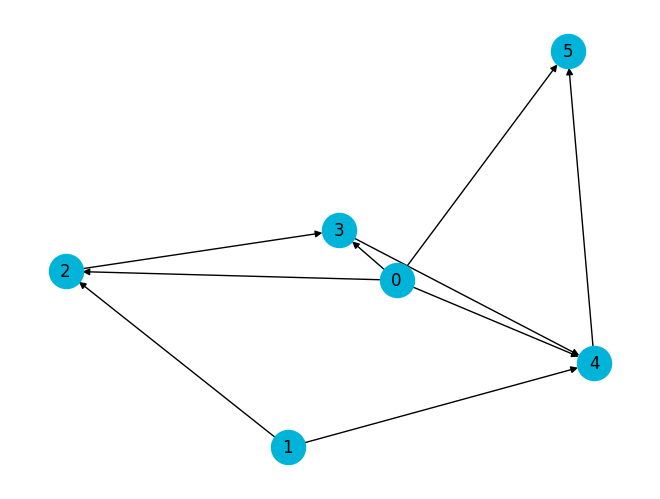

In [6]:
print("Non optimized number of transactions: ", len(F.edges))
print("\nNon optimized graph :", F.draw())

Optimized number of transactions:  6  indeed smaller than  9

Final graph : None


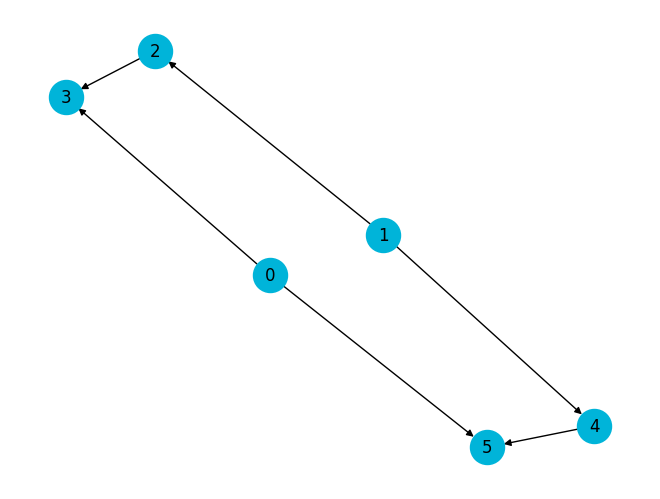

In [7]:
F.Settle()
print("Optimized number of transactions: ", len(F.nonzeroedges)," indeed smaller than ", len(F.edges))
print("\nFinal graph :", F.nonzeroedgDraw())

Let's now calculate the minimum number of edges, key quantity in order to later compute the performance index.

In [8]:
positive_count_toy = 0
negative_count_toy = 0

for balance in net_balance_toy.values():
    if balance > 0:
        positive_count_toy += 1
    elif balance < 0:
        negative_count_toy += 1

#lower bound on the number of edges
E_min_toy = max(positive_count_toy, negative_count_toy)

#F.edges is the initial number of edges
#F.nonzeroedges is the final number of edges, excluding those of zero capacity
index_toy = (len(F.edges) - len(F.nonzeroedges))/(len(F.edges) - E_min_toy)
print(f"Performance index: {index_toy}")

Performance index: 0.5


Let's check if the results match the one manually obtained.

In [9]:
results1 = []
for i in range(len(F.edges)):
	(u,z)=F.edges[i]
	right = F.dicts[u].get(z)
	finalcap=F.adj[u][right].cap
	results1.append((u,z,finalcap))


In [10]:
#1
results1

[(0, 5, 40.0),
 (4, 5, 20.0),
 (0, 4, 0),
 (0, 3, 20.0),
 (3, 4, 0),
 (0, 2, 0),
 (2, 3, 30.0),
 (1, 2, 30.0),
 (1, 4, 10.0)]

## 4. Whole algorithm: real data


### 4.1 Input dataset

In [11]:
!wget https://raw.githubusercontent.com/lugriso/dataset-splitwise/main/input.csv -O input.csv

--2025-04-29 06:44:08--  https://raw.githubusercontent.com/lugriso/dataset-splitwise/main/input.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 882 [text/plain]
Saving to: ‘input.csv’

input.csv           100%[===================>]     882  --.-KB/s    in 0s      

2025-04-29 06:44:08 (53.5 MB/s) - ‘input.csv’ saved [882/882]



In principle we are allowing the csv file to present different transactions for the same pair of people, but since Dinic algorithm is supposed to work with (at most) one edge for each pair of vertices, we first need to collect all the transactions between two fixed people (stored in an edge).

In [12]:
import csv

input = []
max_vertex = -1

with open('input.csv') as fileObject:
    reader_obj = csv.reader(fileObject)

    # Check input values, build input list, det the maximum vertex index
    row_count = 0
    for row in reader_obj:
        row_count += 1
        orig = int(row[0])
        dest = int(row[1])
        cap = float(row[2])

        if cap <= 0:
            raise Exception("Debt is supposed to be positive, not so at row: ", row_count)

        input.append([orig, dest, cap])

        #Update max_vertex if necessary
        max_vertex = max(max_vertex, orig, dest)

#the maximum vertex determines the graph's number of vertices
G = Graph(max_vertex + 1)

#I am going to sum up all the related edges in a single one (e.g. (0, 1, ...) and (1, 0, ...))
# Dictionary to store the net debts between pairs of nodes
debts_input = {}

# Dictionary for the net balance of all the vertices
net_balance_input = {}

for row in input:
    u = int(row[0])
    v = int(row[1])
    amount = float(row[2])

    # Sort the nodes to make the key consistent
    a, b = min(u, v), max(u, v)
    key = (a, b)

    # Determine the direction of the debt
    if u == a:
        debts_input[key] = debts_input.get(key, 0) + amount
    else:
        debts_input[key] = debts_input.get(key, 0) - amount

# Add only the edges with non-zero net debt and update balances
for (a, b), value in debts_input.items():
    if value > 0:
        G.addEdge(a, b, value)
        # update balance
        net_balance_input[a] = net_balance_input.get(a, 0) - value
        net_balance_input[b] = net_balance_input.get(b, 0) + value
    elif value < 0:
        G.addEdge(b, a, -value)
        # update balance
        net_balance_input[b] = net_balance_input.get(b, 0) - (-value)
        net_balance_input[a] = net_balance_input.get(a, 0) + (-value)

Non optimized number of transactions:  77

Non optimized graph : None


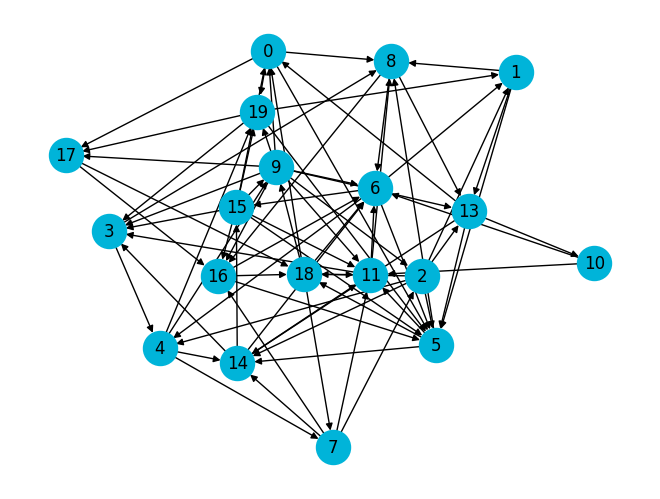

In [13]:
print("Non optimized number of transactions: ", len(G.edges))
print("\nNon optimized graph :", G.draw())


Final graph : None
Optimized number of transactions:  28  indeed smaller than  77


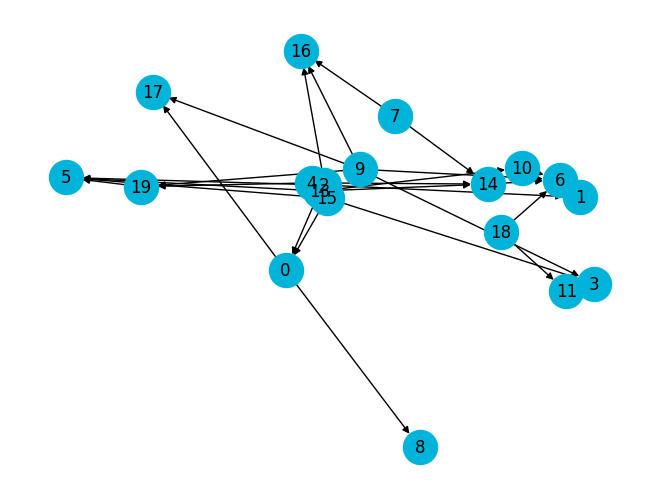

In [14]:
G.Settle()
print("\nFinal graph :", G.nonzeroedgDraw())
print("Optimized number of transactions: ", len(G.nonzeroedges)," indeed smaller than ", len(G.edges))

Let's now calculate the minimum number of edges, key quantity in order to later compute the performance index.

In [15]:
positive_count_input = 0
negative_count_input = 0

for balance in net_balance_input.values():
    if balance > 0:
        positive_count_input += 1
    elif balance < 0:
        negative_count_input += 1

#lower bound on the number of edges
E_min_input = max(positive_count_input, negative_count_input)

#G.edges is the initial number of edges
#G.nonzeroedges is the final number of edges, excluding those of zero capacity
index_input = (len(G.edges) - len(G.nonzeroedges))/(len(G.edges) - E_min_input)
print(f"Performance index: {index_input}")

Performance index: 0.7313432835820896


### 4.2 Input-large dataset

In [16]:
!wget https://raw.githubusercontent.com/lugriso/dataset-splitwise/main/input-large.csv -O input-large.csv

--2025-04-29 06:44:31--  https://raw.githubusercontent.com/lugriso/dataset-splitwise/main/input-large.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8307 (8.1K) [text/plain]
Saving to: ‘input-large.csv’

input-large.csv     100%[===================>]   8.11K  --.-KB/s    in 0.001s  

2025-04-29 06:44:31 (11.0 MB/s) - ‘input-large.csv’ saved [8307/8307]



In principle we are allowing the csv file to present different transactions for the same pair of people, but since Dinic algorithm is supposed to work with (at most) one edge for each pair of vertices, we first need to collect all the transactions between two fixed people (stored in an edge).

In [17]:
import csv

input = []
max_vertex = -1

with open('input-large.csv') as fileObject:
    reader_obj = csv.reader(fileObject)

    # Check input values, build input list, det the maximum vertex index
    row_count = 0
    for row in reader_obj:
        row_count += 1
        orig = int(row[0])
        dest = int(row[1])
        cap = float(row[2])

        if cap <= 0:
            raise Exception("Debt is supposed to be positive, not so at row: ", row_count)

        input.append([orig, dest, cap])

        #Update max_vertex if necessary
        max_vertex = max(max_vertex, orig, dest)

#the maximum vertex determines the graph's number of vertices
H = Graph(max_vertex + 1)

#I am going to sum up all the related edges in a single one (e.g. (0, 1, ...) and (1, 0, ...))
# Dictionary to store the net debts between pairs of nodes
debts_inputl = {}

# Dictionary for the net balance of all the vertices
net_balance_inputl = {}

for row in input:
    u = int(row[0])
    v = int(row[1])
    amount = float(row[2])

    # Sort the nodes to make the key consistent
    a, b = min(u, v), max(u, v)
    key = (a, b)

    # Determine the direction of the debt
    if u == a:
        debts_inputl[key] = debts_inputl.get(key, 0) + amount
    else:
        debts_inputl[key] = debts_inputl.get(key, 0) - amount

# Add only the edges with non-zero net debt and update balances
for (a, b), value in debts_inputl.items():
    if value > 0:
        H.addEdge(a, b, value)
        # update balance
        net_balance_input[a] = net_balance_input.get(a, 0) - value
        net_balance_input[b] = net_balance_input.get(b, 0) + value
    elif value < 0:
        H.addEdge(b, a, -value)
        # update balance
        net_balance_input[b] = net_balance_input.get(b, 0) - (-value)
        net_balance_input[a] = net_balance_input.get(a, 0) + (-value)

In principle we are allowing the csv file to present different transactions for the same pair of people, but since Dinic algorithm is supposed to work with (at most) one edge for each pair of vertices, we first need to collect all the transactions between two fixed people (stored in an edge).

Non optimized number of transactions:   55

Non optimized graph : None


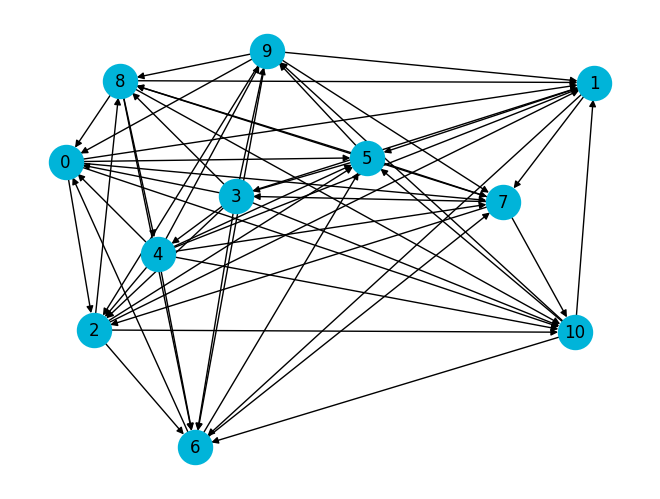

In [18]:
print("Non optimized number of transactions:  ", len(H.edges))
print("\nNon optimized graph :", H.draw())


Final graph : None
Optimized number of transactions:  17  indeed smaller than  55


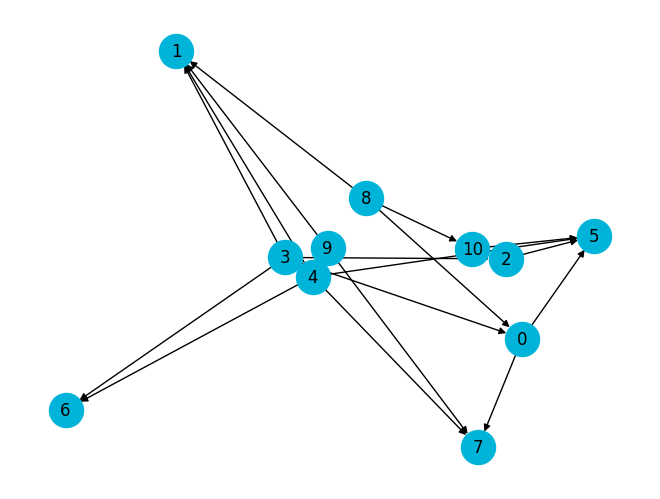

In [19]:
H.Settle()
print("\nFinal graph :", H.nonzeroedgDraw())
print("Optimized number of transactions: ", len(H.nonzeroedges)," indeed smaller than ", len(H.edges))

Let's now calculate the minimum number of edges, key quantity in order to later compute the performance index.

In [20]:
positive_count_inputl = 0
negative_count_inputl = 0

for balance in net_balance_inputl.values():
    if balance > 0:
        positive_count_inputl += 1
    elif balance < 0:
        negative_count_inputl += 1

#lower bound on the number of edges
E_min_inputl = max(positive_count_inputl, negative_count_inputl)

#H.edges is the initial number of edges
#H.nonzeroedges is the final number of edges, excluding those of zero capacity
index_inputl = (len(H.edges) - len(H.nonzeroedges))/(len(H.edges) - E_min_inputl)
print(f"Performance index: {index_inputl}")

Performance index: 0.6909090909090909
